### Checking output of Conv Encoder UpsampleDecoder

In [1]:
cd ..

/home/agajan/DeepMRI


In [2]:
import torch
import torch.nn as nn
from deepmri.Datasets import Volume3dDataset
import deepmri.utils as utils
from DiffusionMRI.ConvEncoder import ConvEncoder
from DiffusionMRI.ConvUpsampleDecoder import ConvUpsampleDecoder
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import time
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [4]:
mu = 307.3646240234375
std = 763.4876098632812
# mu=None
# std=None
batch_size = 1
data_path = '/media/schultz/345de007-c698-4c33-93c1-3964b99c5df6/agajan/experiment_DiffusionMRI/'
# validset = Volume3dDataset(data_path + 'tensors_3d/', mu=mu, std=std)
validset = Volume3dDataset(data_path + 'smallset/test/', mu=mu, std=std)
idx = torch.randint(low=0, high=len(validset)+1, size=(1,))
idx = 0
data = validset[idx].unsqueeze(0) # add batch dim
x_coord = 100
y_coord = 87
z_coord = 73
print("Total examples: ", len(validset))
print("Test volume index: ", idx)
print("DiffusionMRI 1 Volume shape:", data.shape)
print("Minimum voxel value: {}, Maximum voxel value: {}".format(torch.min(data), torch.max(data)))

Total examples:  1
Test volume index:  0
DiffusionMRI 1 Volume shape: torch.Size([1, 1, 145, 174, 145])
Minimum voxel value: -0.40257972478866577, Maximum voxel value: 4.646143913269043


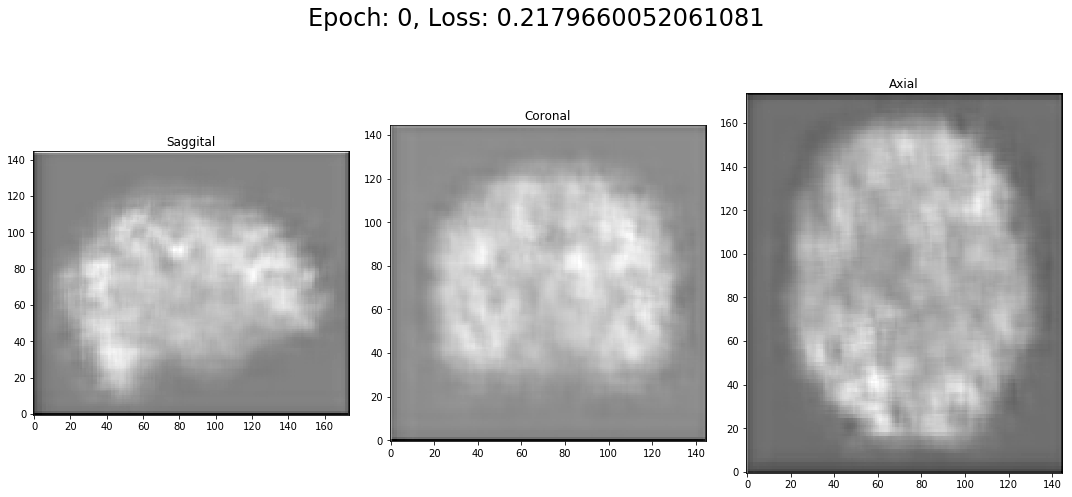

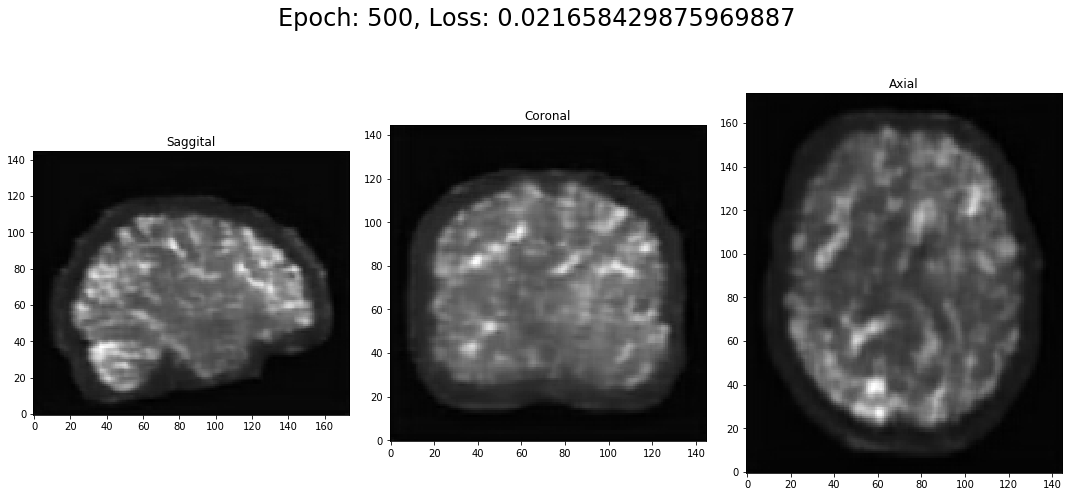

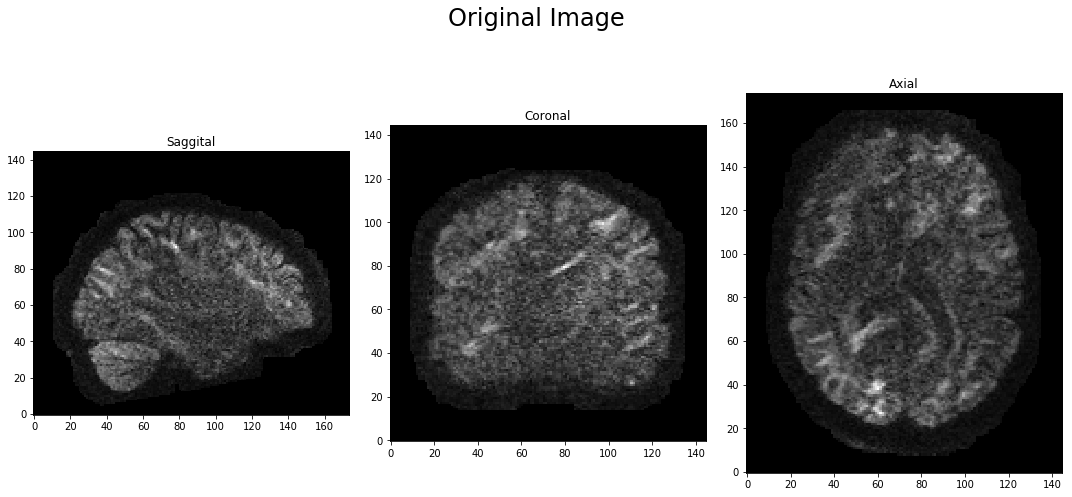

In [5]:
encoder = ConvEncoder(input_channels=1)
encoder.to(device)
encoder.eval()

decoder = ConvUpsampleDecoder(out_channels=1)
decoder.to(device)
decoder.eval()

criterion = nn.MSELoss()

# before training
with torch.no_grad():
    running_loss = 0.0
    encoder.eval()
    decoder.eval()
    
    x = data.to(device)
    out = decoder(encoder(x))
    loss = criterion(x, out)
    running_loss += loss.item() * data.size(0)

epoch_loss = running_loss / 1.
suptitle = "Epoch: {}, Loss: {}".format(0, epoch_loss)
utils.show_slices([
    out[0, 0, x_coord, :, :].cpu().numpy(),
    out[0, 0, :, y_coord, :].cpu().numpy(),
    out[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle=suptitle)
    
# show progress
epochs = [500]
for epoch in epochs:
    encoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/upsample_conv_encoder_epoch_' + str(epoch)
    encoder.load_state_dict(torch.load(encoder_path))
    
    decoder_path = '/home/agajan/DeepMRI/DiffusionMRI/models/upsample_conv_decoder_epoch_' + str(epoch)
    decoder.load_state_dict(torch.load(decoder_path))

    with torch.no_grad():
        running_loss = 0.0
        encoder.eval()
        decoder.eval()
        x = data.to(device)
        out = decoder(encoder(x))
        loss = criterion(x, out)
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / 1.
    suptitle = "Epoch: {}, Loss: {}".format(epoch, running_loss)
    utils.show_slices([
        out[0, 0, x_coord, :, :].cpu().numpy(),
        out[0, 0, :, y_coord, :].cpu().numpy(),
        out[0, 0, :, :, z_coord].cpu().numpy(),
    ], figsize=(15, 8), suptitle=suptitle)

# show original image
utils.show_slices([
    data[0, 0, x_coord, :, :].cpu().numpy(),
    data[0, 0, :, y_coord, :].cpu().numpy(),
    data[0, 0, :, :, z_coord].cpu().numpy(),
], figsize=(15, 8), suptitle="Original Image")

In [6]:
data.min(), data.max()

(tensor(-0.4026), tensor(4.6461))

In [7]:
out.min(), out.max()

(tensor(-0.4712, device='cuda:0'), tensor(2.7581, device='cuda:0'))